In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

import time

from renewable_data_load import *

from threshold_tools import *

# Configure dask for parallel execution
import dask
dask.config.set(scheduler='threads', num_workers=10)  # Adjust num_workers to your CPU cores

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
resource = "pv"
module = "utility"
domain = "d03"
variable = "cf"
frequency = "day"
simulation = "ec-earth3"
reference_gwl = 0.8
future_gwl = 2.0

window_size = 60

In [4]:
# Get bounds for reference GWL period
WRF_sim_name = sim_name_dict[simulation]
model = WRF_sim_name.split("_")[1]
ensemble_member = WRF_sim_name.split("_")[2]
ref_start_year, ref_end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)
fut_start_year, fut_end_year = get_gwl_crossing_period(model, ensemble_member, future_gwl)

## Load the renewables data and associated drought threshold file

In [5]:
threshold_file = f"../data/thresholds/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_10th_pctile.nc"
drought_threshold_ds = xr.open_dataset(threshold_file)
ren_ds = get_ren_data_concat(resource, module, domain, variable, frequency, simulation)
ren_ds = ren_ds.convert_calendar("noleap")

### Reshape the renewables data based on day of year

In [6]:
# reshape array
ds_doy = ren_ds.copy(deep=True)
ds_doy['dayofyear'] = ds_doy.time.dt.dayofyear
ds_doy['year'] = ds_doy.time.dt.year
ds_doy = ds_doy.assign_coords(
    {"dayofyear":ds_doy.time.dt.dayofyear,
    "year":ds_doy.time.dt.year}
)
# reshape time dimension
ds_doy = ds_doy.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

display(ds_doy)

<xarray.DataArray 'cf' (y: 472, x: 223, dayofyear: 365, year: 118)> Size: 36GB
dask.array<reshape, shape=(472, 223, 365, 118), dtype=float64, chunksize=(87, 42, 45, 118), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear          (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
  * year               (year) int64 944B 1981 1982 1983 1984 ... 2096 2097 2098
  * x                  (x) float64 2kB -4.305e+06 -4.302e+06 ... -3.639e+06
  * y                  (y) float64 4kB 4.849e+05 4.879e+05 ... 1.898e+06
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 421kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 421kB 30.35 30.37 30.38 ... 44.49 44.51
    lon                (y, x) float32 421kB -117.7 -117.7 ... -120.9 -120.9
Attributes:
    data_type:             Gridded
    extended_description:  Ratio of power generated to panel nameplate capacity.
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             capacity factor
    units:                 1

### Subtract the threshold to get "drought" metric

In [7]:
drought_ds = (ds_doy - drought_threshold_ds.reference_gen).load()

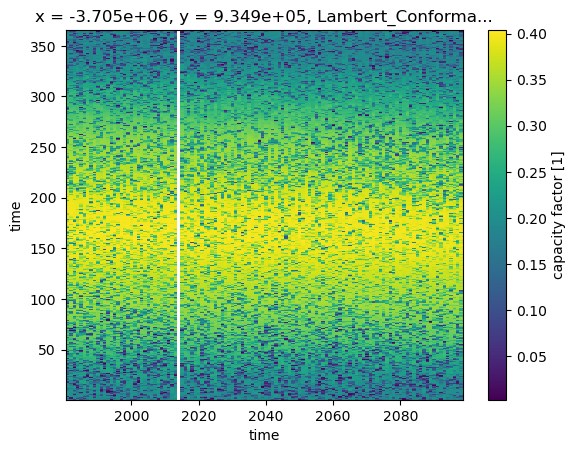

In [6]:
ds_doy.isel(x=200,y=150).plot(x='year',y='dayofyear', cmap='viridis')

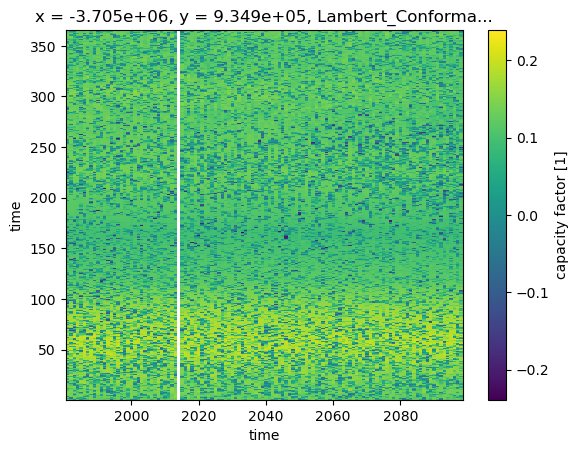

In [7]:
drought_ds.isel(x=200,y=150).plot(x='year',y='dayofyear', cmap='viridis')

In [8]:
# reshape back into daily timeseries
drought_ds = drought_ds.stack(time=['year','dayofyear'])
drought_ds = drought_ds.reset_index("time").assign_coords(time=ren_ds.time)


### Use threshold tools to find drought events

In [9]:
from threshold_tools import *
from threshold_tools import _get_exceedance_events

In [10]:
# make sure everything is loaded into memory
drought_ds = drought_ds.load()

In [9]:
# Divide into reference and future periods based on GWLs
drought_ds_reference = drought_ds.sel(time=slice(f"{ref_start_year}", f"{ref_end_year}"))
drought_ds_future = drought_ds.sel(time=slice(f"{fut_start_year}", f"{fut_end_year}"))

## Catalog Individual Drought Events

Create a dataset that tracks each individual drought event with its characteristics.

In [13]:
def compute_event_stats_auto(data_values, is_drought_mask, time_values, groupby='year'):
    """
    Compute statistics for all events at a single location, grouped by year or season.
    Returns mean statistics per group (year or season). Pure NumPy implementation.
    
    Parameters
    ----------
    data_values : np.ndarray
        1D array of drought values over time
    is_drought_mask : np.ndarray
        1D boolean array indicating drought days
    time_values : np.ndarray
        1D array of datetime64 or cftime values
    groupby : str
        Either 'year' or 'season' for grouping events
    
    Returns
    -------
    tuple of np.ndarray
        (mean_duration, mean_intensity, mean_magnitude) per group
    """
    from scipy import ndimage
    
    # Convert boolean to int for labeling
    drought_binary = np.where(is_drought_mask, 1, 0)
    
    # Label consecutive drought periods
    labeled_array, num_events = ndimage.label(drought_binary)
    
    if num_events == 0:
        # No events - return empty arrays
        return np.array([]), np.array([]), np.array([])
    
    # Collect event statistics with start times
    durations = np.zeros(num_events, dtype=np.float32)
    intensities = np.zeros(num_events, dtype=np.float32)
    magnitudes = np.zeros(num_events, dtype=np.float32)
    groups = np.zeros(num_events, dtype=np.int32)
    
    for event_id in range(1, num_events + 1):
        event_mask = (labeled_array == event_id)
        event_data = data_values[event_mask]
        start_idx = np.argmax(event_mask)
        start_time = time_values[start_idx]
        
        # Extract year and month from time value (handles both cftime and numpy datetime)
        if hasattr(start_time, 'year'):
            # cftime object
            year = start_time.year
            month = start_time.month
        else:
            # numpy datetime64
            dt = np.datetime64(start_time, 'M')
            year = int(np.datetime64(start_time, 'Y'))
            month = int(dt.astype('datetime64[M]').astype(int) % 12 + 1)
        
        # Store statistics
        idx = event_id - 1
        durations[idx] = np.sum(event_mask)
        intensities[idx] = np.min(event_data)
        magnitudes[idx] = np.sum(event_data)
        
        # Assign group
        if groupby == 'year':
            groups[idx] = year
        elif groupby == 'season':
            # Define seasons: DJF=1, MAM=2, JJA=3, SON=4
            groups[idx] = month % 12 // 3 + 1
        else:
            raise ValueError(f"groupby must be 'year' or 'season', got {groupby}")
    
    # Group by using pure NumPy
    unique_groups = np.unique(groups)
    n_groups = len(unique_groups)
    
    mean_durations = np.zeros(n_groups, dtype=np.float32)
    mean_intensities = np.zeros(n_groups, dtype=np.float32)
    mean_magnitudes = np.zeros(n_groups, dtype=np.float32)
    
    for i, group_val in enumerate(unique_groups):
        group_mask = (groups == group_val)
        mean_durations[i] = np.mean(durations[group_mask])
        mean_intensities[i] = np.mean(intensities[group_mask])
        mean_magnitudes[i] = np.mean(magnitudes[group_mask])
    
    return mean_durations, mean_intensities, mean_magnitudes


def catalog_drought_events_ufunc(drought_ds, threshold_value=0, groupby='year'):
    """
    Vectorized version using apply_ufunc with grouping by year or season.
    
    Uses apply_ufunc to process all locations in parallel, computing mean event
    statistics per year or season. This avoids dealing with variable numbers of
    events per location.
    
    Parameters
    ----------
    drought_ds : xr.DataArray
        Time series of drought metric values (dimensions: time, y, x)
    threshold_value : float
        Threshold below which values are considered drought (default: 0)
    groupby : str
        Either 'year' or 'season' for grouping events (default: 'year')
    
    Returns
    -------
    xr.Dataset
        Dataset with dimensions (y, x, group) containing mean event statistics
        where group is either year or season depending on groupby parameter
    """
    import xarray as xr
    import numpy as np
    
    # Identify drought conditions
    is_drought = (drought_ds < threshold_value).where(drought_ds.notnull())
    
    # Convert to boolean (fill NaN with False for processing)
    is_drought_bool = is_drought.fillna(False).astype(bool)
    
    # Extract time values as array for passing to the function
    time_values = drought_ds.time.values
    
    # Use apply_ufunc to process all locations
    # This returns object arrays containing arrays of grouped statistics
    result = xr.apply_ufunc(
        compute_event_stats_auto,
        drought_ds,
        is_drought_bool,
        time_values,
        input_core_dims=[['time'], ['time'], ['time']],
        output_core_dims=[['group'], ['group'], ['group']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float32, np.float32, np.float32],
        kwargs={'groupby': groupby}
    )
    
    mean_durations, mean_intensities, mean_magnitudes = result
    
    # Create dataset
    event_ds = xr.Dataset({
        'mean_drought_duration': mean_durations,
        'mean_max_intensity': mean_intensities,
        'mean_magnitude': mean_magnitudes
    })
    
    # Add metadata
    event_ds['mean_drought_duration'].attrs['units'] = 'days'
    event_ds['mean_drought_duration'].attrs['long_name'] = f'Mean drought event duration per {groupby}'
    
    event_ds['mean_max_intensity'].attrs['units'] = drought_ds.units if hasattr(drought_ds, 'units') else ''
    event_ds['mean_max_intensity'].attrs['long_name'] = f'Mean maximum drought intensity per {groupby}'
    
    event_ds['mean_magnitude'].attrs['units'] = drought_ds.units if hasattr(drought_ds, 'units') else ''
    event_ds['mean_magnitude'].attrs['long_name'] = f'Mean drought magnitude per {groupby}'
    
    event_ds.attrs['threshold_value'] = threshold_value
    event_ds.attrs['groupby'] = groupby
    event_ds.attrs['description'] = f'Mean drought event statistics grouped by {groupby}'
    
    return event_ds

### Test apply_ufunc version

In [14]:
# Test apply_ufunc version (grouped by year)
print("Testing apply_ufunc implementation with year grouping...")
start_time = time.time()

event_catalog_v3 = catalog_drought_events_ufunc(drought_ds_reference, threshold_value=0, groupby='year')

elapsed = time.time() - start_time
print(f"apply_ufunc version completed in {elapsed:.2f} seconds")
print(f"\nDataset has {event_catalog_v3.sizes['group']} groups (years)")

display(event_catalog_v3)

Testing apply_ufunc implementation with year grouping...


ValueError: could not broadcast input array from shape (29,) into shape (0,)

In [12]:
drought_ds_reference

<xarray.DataArray (y: 472, x: 223, time: 10950)> Size: 9GB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.16080831, 0.15808334, 0.15075   , ..., 0.05263334,
         0.13407916, 0.14229167],
        [0.1620875 , 0.15895835, 0.15173335, ..., 0.06146667,
         0.13692918, 0.14441665],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.13167917, 0.12725   , 0.10533333, ..., 0.12132498,
         0.12466667, 0.07008332],
        [0.13208749, 0.11320832, 0.10754167, ..., 0.12189999,
         0.12495001, 0.06770834],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.12750834, 0.124125  , 0.10845417, ..., 0.11540832,
         0.11966249, 0.06108334],
        [0.12770834, 0.10987499, 0.10932083, ..., 0.11615834,
         0.11970417, 0.06345834],
        [0.13283749, 0.10479166, 0.11132917, ..., 0.12260834,
         0.12607917, 0.07095833]]], shape=(472, 223, 10950))
Coordinates:
  * x                  (x) float64 2kB -4.305e+06 -4.302e+06 ... -3.639e+06
  * y                  (y) float64 4kB 4.849e+05 4.879e+05 ... 1.898e+06
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 421kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 421kB 30.35 30.37 30.38 ... 44.49 44.51
    lon                (y, x) float32 421kB -117.7 -117.7 ... -120.9 -120.9
    quantile           float64 8B 0.1
    year               (time) int64 88kB 1988 1988 1988 1988 ... 2017 2017 2017
    dayofyear          (time) int64 88kB 1 2 3 4 5 6 ... 360 361 362 363 364 365
  * time               (time) object 88kB 1988-01-01 00:00:00 ... 2017-12-31 ...
Attributes:
    data_type:             Gridded
    extended_description:  Ratio of power generated to panel nameplate capacity.
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             capacity factor
    units:                 1

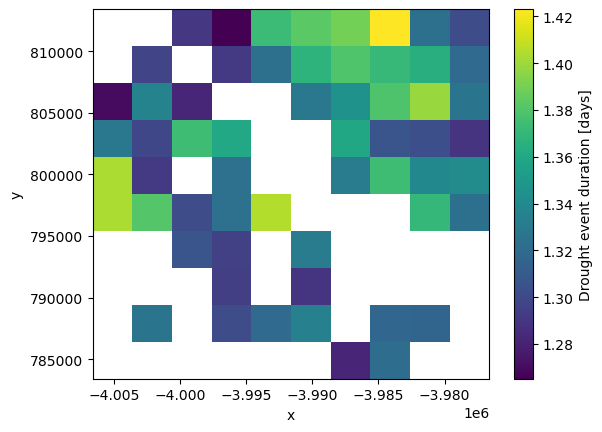

In [ ]:
event_catalog_v3.mean('event_id').drought_duration.plot()

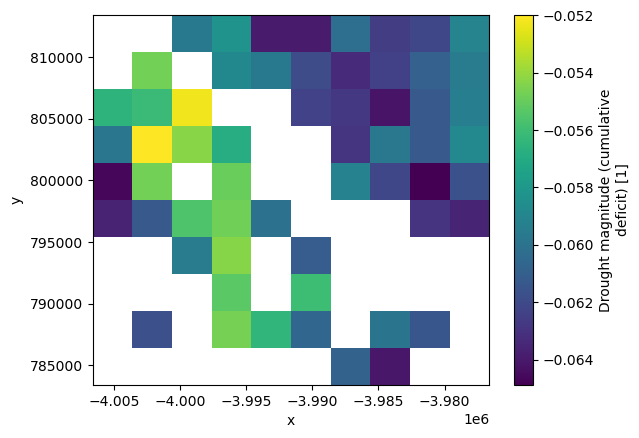

In [49]:
event_catalog_v3.mean('event_id').magnitude.plot()